In [17]:
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
from nptyping import NDArray, Int, Shape, Float, UInt8
from typing import Tuple, Any
from enum import Enum, auto
from PIL import Image
import ipytest
import imageio.v2 as imageio
from dataclasses import dataclass
import os
import pytest
import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s',
    datefmt='%Y-%m-%d:%H:%M:%S',
    level=logging.INFO)
plt.rcParams['figure.figsize'] = [10, 5]
ipytest.autoconfig()

NPImageType = NDArray[Shape["*, *"], UInt8]
XType = NDArray[Shape["*, *, *"], UInt8]
YType = NDArray[Shape["*"], np.int64]


@dataclass
class Dataset:
    def __init__(self, x, y):
        self.x: XType = x
        self.y: YType = y


"""These classes describe Viola-Jones feature"""


class ViolaJonesFeatureType(Enum):
    A = 1
    B = 2
    C = 3
    D = 4


@dataclass
class FeatureDescriptor:
    type: ViolaJonesFeatureType
    x1: int
    y1: int
    x2: int
    y2: int

    def __init__(self, featuretype, x1, y1, x2, y2):
        self.type = featuretype
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2


def compute_cumsum_matrix(a: NDArray[Shape["*, *"], UInt8]) -> NDArray[Shape["*, *"], np.int64]:
    return np.cumsum(np.cumsum(a, axis=0), axis=1)


def compute_submatrix_sum_from_cumsum(a: NDArray[Shape["*, *"], UInt8], x1: int, y1: int, x2: int, y2: int) -> int:
    assert 0 <= x1 <= x2 < a.shape[0]
    assert 0 <= y1 <= y2 < a.shape[1]
    return sum([a[x2][y2],
                -[0, a[x1 - 1][y2]][x1 > 0],
                [0, a[x1 - 1][y1 - 1]][x1 > 0 and y1 > 0],
                -[0, a[x2][y1 - 1]][y1 > 0]])


def compute_a_feature_from_cumsum(a: NDArray[Shape["*, *"], np.int64], x1: int, y1: int, x2: int, y2: int) -> int:
    assert 0 <= x1 <= x2 < a.shape[0]
    assert 0 <= y1 <= y2 < a.shape[1]
    if (y2 - y1) % 2 == 0:
        raise ValueError
    bordery = (y1 + y2) // 2
    return compute_submatrix_sum_from_cumsum(a, x1, y1, x2, bordery) - compute_submatrix_sum_from_cumsum(a, x1,
                                                                                                         bordery + 1,
                                                                                                         x2, y2)


def compute_b_feature_from_cumsum(a: NDArray[Shape["*, *"], np.int64], x1: int, y1: int, x2: int, y2: int) -> int:
    assert 0 <= x1 <= x2 < a.shape[0]
    assert 0 <= y1 <= y2 < a.shape[1]
    if (x2 - x1) % 2 == 0:
        raise ValueError
    borderx = (x1 + x2) // 2
    return compute_submatrix_sum_from_cumsum(a, x1, y1, borderx, y2) - compute_submatrix_sum_from_cumsum(a, borderx + 1,
                                                                                                         y1, x2, y2)


def compute_c_feature_from_cumsum(a: NDArray[Shape["*, *"], np.int64], x1: int, y1: int, x2: int, y2: int) -> int:
    assert 0 <= x1 <= x2 < a.shape[0]
    assert 0 <= y1 <= y2 < a.shape[1]
    if (y2 - y1 + 1) % 3 != 0:
        raise ValueError
    y_1 = y1 + (y2 - y1) // 3
    y_2 = y1 + (y2 - y1) * 2 // 3
    return sum([compute_submatrix_sum_from_cumsum(a, x1, y1, x2, y_1),
                -compute_submatrix_sum_from_cumsum(a, x1, y_1 + 1, x2, y_2),
                compute_submatrix_sum_from_cumsum(a, x1, y_2 + 1, x2, y2)])


def compute_d_feature_from_cumsum(a: NDArray[Shape["*, *"], np.int64], x1: int, y1: int, x2: int, y2: int) -> int:
    assert 0 <= x1 <= x2 < a.shape[0]
    assert 0 <= y1 <= y2 < a.shape[1]
    if (y1 - y2 + 1) % 2 != 0 or (x1 - x2 + 1) % 2 != 0:
        raise ValueError
    bordery = (y1 + y2) // 2
    borderx = (x1 + x2) // 2
    return sum([compute_submatrix_sum_from_cumsum(a, x1, y1, borderx, bordery),
                compute_submatrix_sum_from_cumsum(a, borderx + 1, bordery + 1, x2, y2),
                -compute_submatrix_sum_from_cumsum(a, x1, bordery + 1, borderx, y2),
                -compute_submatrix_sum_from_cumsum(a, borderx + 1, y1, x2, bordery)])


def generate_feature_decriptors(rows: int, cols: int) -> list[FeatureDescriptor]:
    answer = []

    for x1 in range(0, rows, 8):
        for x2 in range(x1 + 5, min(rows, x1 + 50), 7):
            for y1 in range(0, cols, 8):
                for y2 in range(y1 + 5, min(cols, y1 + 50), 7):
                    if (y2 - y1) % 2 == 1:
                        answer.append(FeatureDescriptor(ViolaJonesFeatureType.A, x1, y1, x2, y2))

    for x1 in range(0, rows, 8):
        for x2 in range(x1 + 5, min(rows, x1 + 50), 7):
            for y1 in range(0, cols, 8):
                for y2 in range(y1 + 5, min(cols, y1 + 50), 7):
                    if (x2 - x1) % 2 == 1:
                        answer.append(FeatureDescriptor(ViolaJonesFeatureType.B, x1, y1, x2, y2))

    for x1 in range(0, rows, 20):
        for x2 in range(x1 + 5, min(rows, x1 + 40), 20):
            for y1 in range(0, cols, 20):
                for y2 in range(y1 + 5, min(cols, y1 + 40), 20):
                    if (y2 - y1) % 3 == 2:
                        answer.append(FeatureDescriptor(ViolaJonesFeatureType.C, x1, y1, x2, y2))

    for x1 in range(0, rows, 14):
        for x2 in range(x1 + 5, min(rows, x1 + 40), 20):
            for y1 in range(0, cols, 14):
                for y2 in range(y1 + 5, min(cols, y1 + 40), 20):
                    if (y2 - y1) % 2 == 1 and (x2 - x1) % 2 == 1:
                        answer.append(FeatureDescriptor(ViolaJonesFeatureType.D, x1, y1, x2, y2))
    return answer


def generate_feature_from_cumsum(a: NDArray[Shape["*, *"], UInt8], fd: FeatureDescriptor) -> int:
    if fd.type == ViolaJonesFeatureType.A:
        return compute_a_feature_from_cumsum(a, fd.x1, fd.y1, fd.x2, fd.y2)
    elif fd.type == ViolaJonesFeatureType.B:
        return compute_b_feature_from_cumsum(a, fd.x1, fd.y1, fd.x2, fd.y2)
    elif fd.type == ViolaJonesFeatureType.C:
        return compute_c_feature_from_cumsum(a, fd.x1, fd.y1, fd.x2, fd.y2)
    elif fd.type == ViolaJonesFeatureType.D:
        return compute_d_feature_from_cumsum(a, fd.x1, fd.y1, fd.x2, fd.y2)
    raise ValueError("Unknown feature type")


@dataclass
class ViolaJonesDataset:
    x: NDArray[Shape["Any, Any"], np.int64]
    y: NDArray[Shape["Any"], np.int64]
    feature_descriptors: list[FeatureDescriptor]


def generate_viola_jones_dataset(dataset: Dataset, fds: list[FeatureDescriptor]) -> ViolaJonesDataset:
    n = len(dataset.x)
    m = len(fds)
    x = np.zeros((n, m), dtype=np.int64)
    for i, image in enumerate(dataset.x):
        a = compute_cumsum_matrix(image)
        for j, fd in enumerate(fds):
            try:
                x[i, j] = generate_feature_from_cumsum(a, fd)
            except OverflowError:
                x[i, j] = 10 ** 9
    return ViolaJonesDataset(x=x, y=dataset.y, feature_descriptors=fds)


class DecisionStumpType(Enum):
    POSITIVE_ON_RIGHT = 1
    POSITIVE_ON_LEFT = 2


@dataclass
class DecisionStump:
    threshold: float
    type: DecisionStumpType

    def classify(self, x: float) -> int:
        if self.type is DecisionStumpType.POSITIVE_ON_RIGHT and x > self.threshold:
            return 1
        if self.type is DecisionStumpType.POSITIVE_ON_LEFT and x < self.threshold:
            return 1
        return -1


def find_best_descision_stump(
        xs: NDArray[Shape["Any"], Any],
        ys: NDArray[Shape["Any"], np.int64],
        ws: NDArray[Shape["Any"], np.float32] = None) -> Tuple[DecisionStump, float]:
    if ws is None:
        ws = np.ones_like(xs, dtype=np.float32) / len(xs)

    best_stump = DecisionStump(xs[0] - 1, DecisionStumpType.POSITIVE_ON_RIGHT)
    best_type = DecisionStumpType.POSITIVE_ON_RIGHT
    best_threshold = xs[0] - 1
    best_score = score_decision_stump(best_stump, xs, ys, ws)
    score = best_score
    for i in range(len(xs) - 1):
        if ys[i] == -1:
            score += ws[i]
        else:
            score -= ws[i]

        if score > best_score:
            best_score = score
            best_threshold = (xs[i] + xs[i + 1]) / 2
            best_type = DecisionStumpType.POSITIVE_ON_RIGHT

    if ys[-1] == -1:
        score += ws[-1]
    else:
        score -= ws[-1]

    if score > best_score:
        best_score = score
        best_threshold = xs[-1] + 1
        best_type = DecisionStumpType.POSITIVE_ON_RIGHT

    stump = DecisionStump(xs[0] - 1, DecisionStumpType.POSITIVE_ON_LEFT)
    score = score_decision_stump(stump, xs, ys, ws)

    if score > best_score:
        best_score = score
        best_threshold = xs[0] - 1
        best_type = DecisionStumpType.POSITIVE_ON_LEFT

    for i in range(len(xs) - 1):
        if ys[i] == -1:
            score -= ws[i]
        else:
            score += ws[i]

        if score > best_score:
            best_score = score
            best_threshold = (xs[i] + xs[i + 1]) / 2
            best_type = DecisionStumpType.POSITIVE_ON_LEFT

    if ys[-1] == -1:
        score -= ws[-1]
    else:
        score += ws[-1]

    if score > best_score:
        best_score = score
        best_threshold = xs[-1] + 1
        best_type = DecisionStumpType.POSITIVE_ON_LEFT

    return DecisionStump(best_threshold, best_type), best_score


def score_decision_stump(
        stump: DecisionStump,
        xs: NDArray[Shape["Any"], Any],
        ys: NDArray[Shape["Any"], np.int64],
        ws: NDArray[Shape["Any"], np.float32] = None) -> float:
    if ws is None:
        ws = np.ones_like(xs, dtype=np.float32) / len(xs)
    answer = 0

    for x, y, w in zip(xs, ys, ws):
        if stump.classify(x) == y:
            answer += w
    return answer


@dataclass
class MyWeakClassifier:
    stump: DecisionStump
    fd: FeatureDescriptor
    weight: float

    def score_from_cumsum(self, a: NDArray[Shape["*, *"], np.int64]) -> float:
        value = generate_feature_from_cumsum(a, self.fd)
        return self.stump.classify(value) * self.weight


def my_score(classifier: list[MyWeakClassifier], image: NPImageType) -> float:
    a = compute_cumsum_matrix(image)
    return sum(clf.score_from_cumsum(a) for clf in classifier)


def my_classify(classifier: list[MyWeakClassifier], image: NPImageType) -> int:
    return np.sign(my_score(classifier, image))


def train_viola_jones_adaboost(data: ViolaJonesDataset, T: int) -> list[MyWeakClassifier]:
    nfeatures = len(data.feature_descriptors)
    nsamples = len(data.x)
    assert data.x.shape[1] == nfeatures

    logger.info('Starting to sort dataset by features')
    order_by_feature = []
    for i in range(nfeatures):
        order_by_feature.append(np.argsort(data.x[:, i]))
    logger.info('Finished to sort dataset by features')

    result = []
    D = np.full(nsamples, 1. / nsamples, dtype=np.float32)
    for t in range(T):
        best_fd, best_stump, best_score, best_feature_idx = None, None, None, None
        for i, fd in enumerate(data.feature_descriptors):
            stump, score = find_best_descision_stump(
                data.x[:, i][order_by_feature[i]],
                data.y[order_by_feature[i]],
                D[order_by_feature[i]]
            )
            if best_score is None or score > best_score:
                best_fd, best_stump, best_score, best_feature_idx = fd, stump, score, i
        logger.info(
            'Found new weak hypothesis (fd=%s, threshold=%.2f, type=%s, score=%.2f)',
            best_fd, best_stump.threshold, best_stump.type, best_score)
        assert 0.5 <= best_score <= 1
        error = 1. - best_score
        alpha = 0.5 * np.log(best_score / error)

        for i in range(nsamples):
            D[i] = D[i] * np.exp(-alpha * data.y[i] * best_stump.classify(data.x[i][best_feature_idx]))
        D = D / np.sum(D)

        result.append(MyWeakClassifier(stump=best_stump, fd=best_fd, weight=alpha))
    return result


def normalize_img(x):
    return np.array(Image.fromarray(x[:, :, 0]).resize((100, 120)))


class AdaboostClassifier:
    def __init__(self):
        self.STEPS = 35
        self.classifier = None

    def fit(self, xs, ys):
        """ 
        Train a classifier.
        params:
        xs: list of np.arrays with shapes (3, *, *): .bmp files
        read with imageio.imread
        ys: list of labels: -1 and 1
        """
        data = Dataset(np.array([normalize_img(x) for x in xs]), ys)
        FDS = generate_feature_decriptors(data.x[0].shape[0], data.x[0].shape[1])
        VJ_TRAIN = generate_viola_jones_dataset(data, FDS)
        self.classifier = train_viola_jones_adaboost(VJ_TRAIN, self.STEPS)

    def predict(self, x):
        """ 
        Predict an image class with a fitted classifier.
        params:
        x: np.array with shape (3, *, *)
        returns: label -1 or 1
        """
        return my_classify(self.classifier, normalize_img(x))

In [18]:
def load_image_from_file(fname: str) -> NPImageType:
    image = Image.open(fname)
    image.load()
    return np.array(image)
@dataclass(order=True)
class FilenameAndImage:
    
    def __init__(self, filename: str, image):
        self.filename: str = filename
        self.image = image

def load_all_images_from_folder(folder: str) -> list[FilenameAndImage]:
    """Load (load_image_from_file) all .bmp file from folder and return list of results with filenames."""
    answer: list[FilenameAndImage] = []
    
    for img in os.listdir(folder):
        path = '/'.join([folder, img])
        image = load_image_from_file(path)
        answer.append(FilenameAndImage(img ,image))
    
    return answer

def load_whole_dataset(folders: list[str], labels: list[int]) -> Dataset:
    """Take two lists with the same lengths. For the i-th folder load all images and assign label the i-th label"""
    x = []
    y = []
    for folder, label in zip(folders, labels):
        filenamesandimages = load_all_images_from_folder(folder)
        x.extend([val.image for val in filenamesandimages])
        y.extend([label] * len(filenamesandimages))
    return Dataset(np.array(x), np.array(y))

def load_canonized_dataset() -> Dataset:
    return load_whole_dataset(['Train/Female', 'Train/Male'], [-1, 1])

WHOLE_DATASET = load_canonized_dataset()

def make_canonized_splits(dataset, test_size=0.1) -> Tuple[Dataset, Dataset]:
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
        dataset.x, dataset.y,
        test_size=test_size,
        random_state=0
    )
    return Dataset(x_train, y_train), Dataset(x_test, y_test)

TRAIN_DATASET, TEST_DATASET = make_canonized_splits(WHOLE_DATASET)

In [19]:
ada = AdaboostClassifier()
ada.fit(TRAIN_DATASET.x, TRAIN_DATASET.y)

2022-12-05:00:23:33 INFO     [2163235416.py:308] Starting to sort dataset by features
2022-12-05:00:23:34 INFO     [2163235416.py:312] Finished to sort dataset by features
2022-12-05:00:24:00 INFO     [2163235416.py:326] Found new weak hypothesis (fd=FeatureDescriptor(type=<ViolaJonesFeatureType.B: 2>, x1=56, y1=32, x2=61, y2=37), threshold=560.50, type=DecisionStumpType.POSITIVE_ON_LEFT, score=0.77)
2022-12-05:00:24:25 INFO     [2163235416.py:326] Found new weak hypothesis (fd=FeatureDescriptor(type=<ViolaJonesFeatureType.D: 4>, x1=56, y1=42, x2=61, y2=67), threshold=-703.50, type=DecisionStumpType.POSITIVE_ON_RIGHT, score=0.73)
2022-12-05:00:24:52 INFO     [2163235416.py:326] Found new weak hypothesis (fd=FeatureDescriptor(type=<ViolaJonesFeatureType.B: 2>, x1=64, y1=48, x2=83, y2=60), threshold=2390.50, type=DecisionStumpType.POSITIVE_ON_RIGHT, score=0.72)
2022-12-05:00:25:17 INFO     [2163235416.py:326] Found new weak hypothesis (fd=FeatureDescriptor(type=<ViolaJonesFeatureType.B: 

In [25]:
TRAIN_DATASET.y[TRAIN_DATASET.y == 1].shape

(1129,)

In [22]:
ada.predict(TRAIN_DATASET.x[5])

1.0

In [26]:
def compute_learning_curve(clf: list[MyWeakClassifier], dataset: Dataset) -> list[float]:
    T = len(clf)
    result = []
    for steps in range(0, T, 3):
        current = clf[:steps + 1]
        correct = sum(1 for image, label in zip(dataset.x, dataset.y) if my_classify(current, normalize_img(image)) == label)
        result.append(correct / len(dataset.x))
    return result

In [27]:
train_curve = compute_learning_curve(ada.classifier, TRAIN_DATASET)
test_curve = compute_learning_curve(ada.classifier, TEST_DATASET)

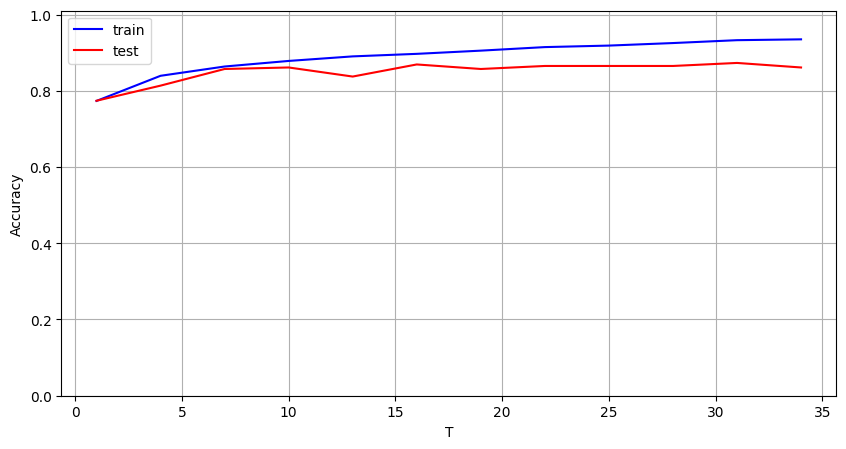

In [29]:
fig, ax = plt.subplots()

ax.set_ylim((0, 1.01))
ax.plot(np.arange(1, 35 + 1, 3), train_curve, 'b', label='train')
ax.plot(np.arange(1, 35 + 1, 3), test_curve, 'r', label='test')

ax.set(xlabel='T', ylabel='Accuracy')
ax.grid()
ax.legend()

plt.show()

In [30]:
current = ada.classifier
correct = sum(1 for image, label in zip(TEST_DATASET.x, TEST_DATASET.y) if my_classify(current, normalize_img(image)) == label)
correct / len(TEST_DATASET.x)

0.8650793650793651

-1.0

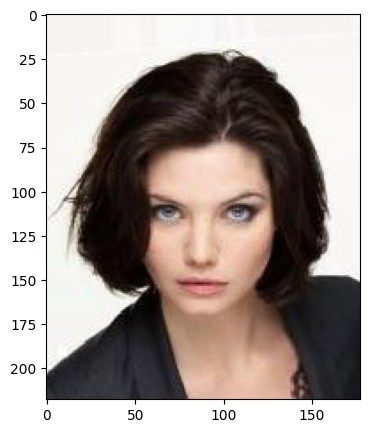

In [89]:
ar = TEST_DATASET.x[88]
plt.imshow(ar, cmap='gray')
ada.predict(ar)

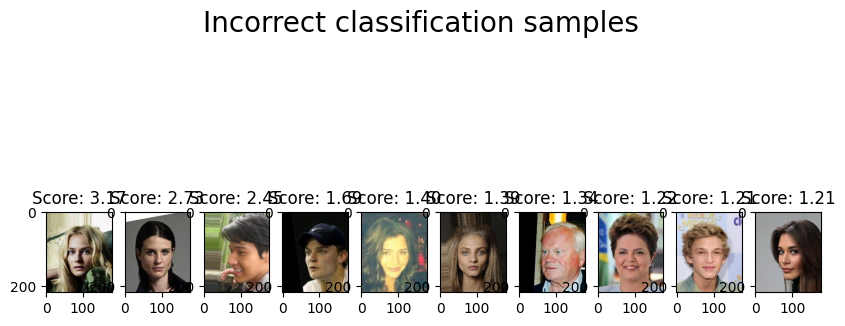

In [86]:
WORST = 10

score_and_image = []
for image, label in zip(TEST_DATASET.x, TEST_DATASET.y):
    score = my_score(ada.classifier, normalize_img(image))
    if score * label < 0:
        score_and_image.append((np.abs(score), image))
score_and_image.sort(reverse=True)
score_and_image = score_and_image[:WORST]
    
fig, axs = plt.subplots(1, WORST)
fig.suptitle('Incorrect classification samples', fontsize=20)
for ax, (score, image) in zip(axs, score_and_image):
    ax.imshow(image, cmap='gray')
    ax.set_title('Score: {:.2f}'.format(score))
plt.show()